In [136]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as colors
import matplotlib as mpl
% matplotlib inline

In [137]:
filename = '../Data/cleaned_data.csv'
df = pd.read_csv(filename)
df = df.replace('S SAN FRANCISCO', 'SOUTH SAN FRANCISCO')
df = df.replace('SO. SAN FRANCISCO', 'SOUTH SAN FRANCISCO')
df = df.replace('REDWOOD SHORES', 'REDWOOD CITY')
df = df[df['CITY'] != 'Out of Area']
df = df[df['CITY'] != 'OUT OF AREA ']
df = df[df['CITY'] != 'OUTSIDE ARIZONA']
df = df.drop(['Unnamed: 0', 'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)', 'SOURCE', 'MLS#'], axis=1)

In [138]:
cacounty = gpd.read_file('../Data/County/CaliforniaCounty.shp')
SMC = cacounty.loc[cacounty['NAME']== 'San Mateo']
SCC = cacounty.loc[cacounty['NAME']== 'Santa Clara']
ALC = cacounty.loc[cacounty['NAME']== 'Alameda']
SFC = cacounty.loc[cacounty['NAME']== 'San Francisco']
baycounty = SMC.append(SCC).append(ALC).append(SFC)

In [139]:
cacities = gpd.read_file('../Data/cities/Cities2015.shp')
cacities['NAME'] = cacities['NAME'].astype(str).apply(lambda city: city.upper())
cities = df['CITY'].unique()

In [140]:
baycities = pd.DataFrame()
for city in cacities['NAME']:
    if city in cities:
        X = cacities.loc[cacities['NAME'] == city]
        baycities = baycities.append(X)  
baycities = baycities.drop_duplicates(subset = ['NAME', 'County'])

In [141]:
df_na = df.replace('', np.nan)
df_pcounty = df_na.dropna(subset = ['PRICE IN K', 'COUNTY']) 
price_by_county = df_pcounty.groupby('COUNTY')['PRICE IN K'].mean()
price_by_county = price_by_county.reset_index()

df_sqft_county = df_na.dropna(subset = ['$/SQUARE FEET', 'COUNTY']) 
unitprice_by_county = df_sqft_county.groupby('COUNTY')['$/SQUARE FEET'].mean()
unitprice_by_county = unitprice_by_county.reset_index()

df_pcity = df_na.dropna(subset = ['PRICE IN K','CITY']) 
price_by_city = df_pcity.groupby('CITY')['PRICE IN K'].mean()
price_by_city= price_by_city.reset_index()

df_sqft_city = df_na.dropna(subset = ['$/SQUARE FEET', 'CITY']) 
unitprice_by_city = df_sqft_city.groupby('CITY')['$/SQUARE FEET'].mean()
unitprice_by_city = unitprice_by_city.reset_index()

In [142]:
countproperty_bycity = df_pcity.groupby('CITY')['ADDRESS'].count()
countproperty_bycity = countproperty_bycity.reset_index()
countproperty_bycity.columns = ['NAME', 'PROP COUNT']

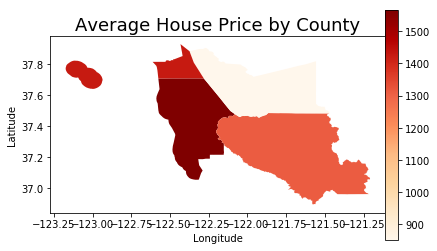

In [143]:
county = ['Alameda', 'San Francisco', 'San Mateo', 'Santa Clara']
price_by_county['NAME'] = county
county_geo = pd.merge(baycounty, price_by_county, on='NAME')
# county_geo = gpd.sjoin(baycounty, price_by_county, how='inner', op='intersects')
norm = mpl.colors.Normalize(vmin=5, vmax=10)
ax=county_geo.plot(column='PRICE IN K', cmap='OrRd', norm=norm)
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=norm)
fig = ax.get_figure()
plt.title('Average House Price by County', {'fontsize': 18})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
plt.show()

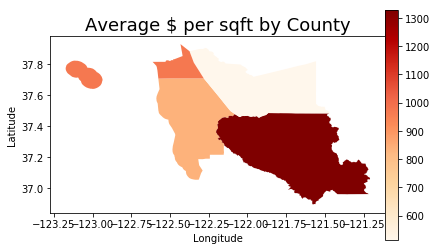

In [144]:
county = ['Alameda', 'San Francisco', 'San Mateo', 'Santa Clara']
unitprice_by_county['NAME'] = county
unit_county_geo = pd.merge(baycounty, unitprice_by_county, on='NAME')
norm = mpl.colors.Normalize(vmin=5, vmax=10)
ax=unit_county_geo.plot(column='$/SQUARE FEET', cmap='OrRd', norm=norm)
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=norm)
fig = ax.get_figure()
plt.title('Average $ per sqft by County', {'fontsize': 18})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
plt.show()

In [145]:
cacities['NAME'] = cacities['NAME'].astype(str).apply(lambda city: city.upper())

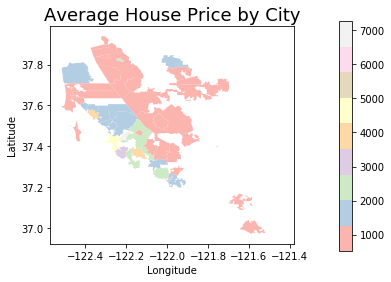

In [146]:
price_by_city.columns = ['NAME', 'PRICE IN K']
city_geo = pd.merge(baycities, price_by_city, on='NAME')
norm = mpl.colors.Normalize(vmin=5, vmax=10)
ax=city_geo.plot(column='PRICE IN K', cmap='Pastel1', norm=norm)
sm = plt.cm.ScalarMappable(cmap='Pastel1', norm=norm)
fig = ax.get_figure()
plt.title('Average House Price by City', {'fontsize': 18})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
plt.show()

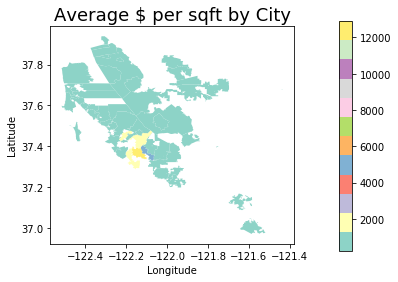

In [147]:
unitprice_by_city.columns = ['NAME', '$/SQUARE FEET']
unit_city_geo = pd.merge(baycities, unitprice_by_city, on='NAME')
norm = mpl.colors.Normalize(vmin=5, vmax=10)
ax=unit_city_geo.plot(column='$/SQUARE FEET', cmap='Set3', norm=norm)
sm = plt.cm.ScalarMappable(cmap='Set3', norm=norm)
fig = ax.get_figure()
plt.title('Average $ per sqft by City', {'fontsize': 18})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
plt.show()

In [148]:
city_geo_price = pd.merge(city_geo, unitprice_by_city, on='NAME')
city_geo_price = pd.merge(city_geo_price, countproperty_bycity, on='NAME')
city_geo_price = gpd.GeoDataFrame(city_geo_price, geometry = city_geo_price.geometry)
city_geo_price.to_file(driver = 'ESRI Shapefile', filename= "../Data/city_geo_price.shp")

In [149]:
city_geo_price

,NAME,CityType,Pop2010,Land_sqmi,DateIncorp,WebLink,County,Notes,CityAbbv,geometry,PRICE IN K,$/SQUARE FEET,PROP COUNT
0,GILROY,City,48821,16.15,1870-03-12,http://www.cityofgilroy.org,Santa Clara,,Gil,POLYGON ((-121.5891064263205 37.04772893374334...,646.106441,372.476464,871
1,MORGAN HILL,City,37882,12.88,1906-11-10,http://www.morgan-hill.ca.gov,Santa Clara,,MgH,POLYGON ((-121.6429347991943 37.16795921325684...,756.034287,436.310734,712
2,MONTE SERENO,City,3341,1.62,1957-05-14,http://www.montesereno.org,Santa Clara,,MSo,POLYGON ((-121.9772510528564 37.25112342834473...,2906.868182,906.576642,137
3,LOS GATOS,Town,29413,11.08,1887-08-10,http://www.losgatosca.gov,Santa Clara,43-15-008,LGts,"POLYGON ((-121.9539885568182 37.2122263955635,...",1495.784129,790.529252,737
4,SARATOGA,City,29926,12.38,1956-10-22,http://www.saratoga.ca.us,Santa Clara,,Sar,POLYGON ((-122.0027252414766 37.29376939544144...,2050.101130,954.887500,561
5,CAMPBELL,City,39349,5.80,1952-03-28,http://www.cityofcampbell.com,Santa Clara,,Cmb,"POLYGON ((-121.9391632080078 37.2730884552002,...",1046.834555,733.161342,629
6,CUPERTINO,City,58302,11.26,1955-10-10,http://www.cupertino.org,Santa Clara,,Cpo,POLYGON ((-122.0436935424805 37.33400917053223...,1521.140599,1035.771777,574
7,LOS ALTOS HILLS,Town,7922,8.80,1956-01-27,http://www.losaltoshills.ca.gov,Santa Clara,,LAH,POLYGON ((-122.1636123657227 37.38809776306152...,4114.915214,12930.619217,281
8,SAN JOSE,City,945942,176.53,1850-03-27,http://www.sanjoseca.gov,Santa Clara,,SJs,"POLYGON ((-121.75232046162 37.40037535543836, ...",748.624957,635.687473,2281
9,LOS ALTOS,City,28976,6.49,1952-12-01,http://www.ci.los-altos.ca.us,Santa Clara,,LAts,"POLYGON ((-122.1189498901367 37.4055347442627,...",2589.557875,5222.766026,624
